<a href="https://colab.research.google.com/github/BoKna031/ImageInpainting/blob/master/ImageInpaintingCIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
print('Train images shape:', train_images.shape)
print('Train labels shape:', train_labels.shape)
print('Test images shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


Show of some pictures

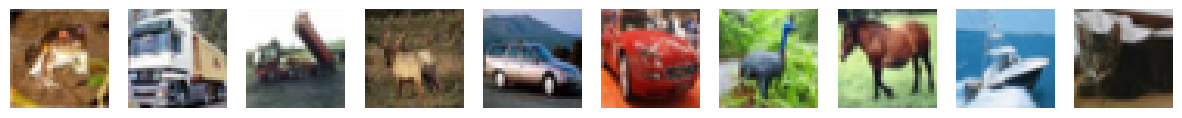

In [4]:
import matplotlib.pyplot as plt

# Prikaz prvih 10 slika iz trening skupa
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(train_images[i])
    axes[i].axis('off')
plt.show()

# Preparation of Non-Blind Inpainting images

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def non_blind_image(image):
  modified_image = np.copy(image)
  center_x = image.shape[0] // 2
  center_y = image.shape[1] // 2
  modified_image[center_x-5:center_x+5, center_y-5:center_y+5, :] = 0

  return modified_image

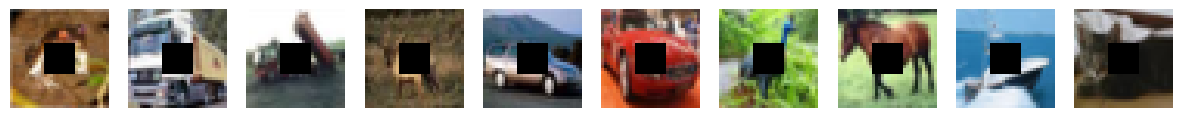

In [12]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(non_blind_image(train_images[i]))
    axes[i].axis('off')
plt.show()

In [6]:
import os
TRAIN_DIR_NAME = "train"
TEST_DIR_NAME = "test"

NON_BLIND_IMG_DIR_NAME = "non_blind"
ORG_IMG_DIR_NAME = "org"
GEN_IMG_DIR_NAME = "gen"

TRAIN_ORG_PATH = TRAIN_DIR_NAME + os.sep + ORG_IMG_DIR_NAME
TRAIN_NB_PATH = TRAIN_DIR_NAME + os.sep + NON_BLIND_IMG_DIR_NAME
TRAIN_GEN_PATH = TRAIN_DIR_NAME + os.sep + GEN_IMG_DIR_NAME

In [7]:
import shutil

try:
  shutil.rmtree(TRAIN_DIR_NAME)
  shutil.rmtree(TEST_DIR_NAME)
  print("Directories successfully deleted.")
except FileNotFoundError:
  print("File not found!")

os.mkdir(TRAIN_DIR_NAME)
os.mkdir(TRAIN_ORG_PATH)
os.mkdir(TRAIN_NB_PATH)
os.mkdir(TRAIN_GEN_PATH)
os.mkdir(TEST_DIR_NAME)
print("Empty directories successfully created.")

Directories successfully deleted.
Empty directories successfully created.


In [8]:
from PIL import Image

for i, img in enumerate(train_images):
  filename = str(i) + "_" + str(train_labels[i][0])
  org_img = Image.fromarray(img)
  nb_img = Image.fromarray(non_blind_image(img))

  org_img.save(TRAIN_ORG_PATH + os.sep + filename + ".png")
  nb_img.save(TRAIN_NB_PATH + os.sep + filename + ".png")

# Networks

Non-Bliond Euclidean without Sigmoid

In [9]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.models import Sequential

In [10]:
model = Sequential()

# Dodavanje konvolucijskih slojeva
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
for i in range(9):
  if (i + 1) % 3 == 0:
     model.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

# Dodavanje potpuno povezanog sloja
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Ispisivanje informacija o modelu
#model.summary()

Non-Blind Euclidean with Sigmoid

In [11]:
model_sigmoid = Sequential()

# Dodavanje konvolucijskih slojeva
model_sigmoid.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
model_sigmoid.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(16, kernel_size=3, padding='same', strides=2, activation='relu'))
model_sigmoid.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(32, kernel_size=3, padding='same', strides=2, activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

# Dodavanje potpuno povezanog sloja
model_sigmoid.add(Flatten())
model_sigmoid.add(Dense(300, activation='relu'))
model_sigmoid.add(Dense(1, activation='sigmoid'))  # Sigmoid sloj
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Ispisivanje informacija o modelu
#model.summary()